In [1]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

In [2]:
def visualize_bloch(psi):
    rho_qubit = psi.ptrace(1)
    bloch = qt.Bloch()
    bloch.add_states(rho_qubit)
    bloch.show()

def visualize_wigner(psi, alpha, title="Wigner Function"):

    rho_cavity = psi.ptrace(0)
    xvec = np.linspace(-3*int(alpha), 3*int(alpha), int(alpha)*100)
    wigner_cavity = qt.wigner(rho_cavity, xvec, xvec)
    wlim = np.abs(wigner_cavity).max()
    
    plt.imshow(
        wigner_cavity, cmap='RdBu_r', vmin=-wlim, vmax=wlim, origin="lower",
        extent=(xvec.min(), xvec.max(), xvec.min(), xvec.max()),
    )
    plt.axhline(0.0, c="tab:gray", alpha=0.25)
    plt.axvline(0.0, c="tab:gray", alpha=0.25)
    plt.title(title)
    plt.xlabel(r"$x$")
    plt.ylabel(r"$p$")
    plt.colorbar()
    plt.show()

Start in the ground state:
    $$\left| \psi_0 \right> = \left|0\right> \otimes \left| \mathrm{g} \right>.$$

In [3]:
wc = 2 * np.pi * 6.0
wq = 2 * np.pi * 5.0
delta = np.abs(wq - wc)

g = 2 * np.pi * 0.10
chi = g**2 / delta

# dissipation constants
kappa = 2 * np.pi * 0.00001
gamma = 2 * np.pi * 0.00001


N = 35
alpha = 2

# Cavity operators
a = qt.tensor(qt.destroy(N), qt.qeye(2))
n = a.dag() * a  # photon number
x = qt.tensor(qt.position(N), qt.qeye(2))
p = qt.tensor(qt.momentum(N), qt.qeye(2))

# Pauli matrices
sx = qt.tensor(qt.qeye(N), qt.sigmax())
sy = qt.tensor(qt.qeye(N), qt.sigmay())
sz = qt.tensor(qt.qeye(N), qt.sigmaz())
sp = qt.tensor(qt.qeye(N), qt.sigmap())
sm = qt.tensor(qt.qeye(N), qt.sigmam())

# identity matrix
eye = qt.tensor(qt.qeye(N), qt.qeye(2))


# Defines the collapse operators for the two cases of dissipation.
c_ops = [
    np.sqrt(kappa) * a,
    np.sqrt(gamma) * sm,
]

# Rotating frame
wrot_c = wc - chi  # cavity frequency when qubit in |g>
wrot_q = wq + chi  # qubit frequency when cavity in |0>

# Time array
fs = 100.0  # sampling frequency, GHz
dt = 1 / fs
T0 = round(abs(np.pi / chi))
T = 4*T0
ns_tot = int(round(fs * T)) + 1 # nr of samples
tlist = np.linspace(0, T, ns_tot)

# Hamiltonian
H0 = (wc - wrot_c) * (a.dag() * a + eye / 2) + 0.5 * (wq - wrot_q) * sz
H = [H0]

V = chi * (a.dag() * a + eye / 2) * sz  # dispersive interaction
H.append(V)

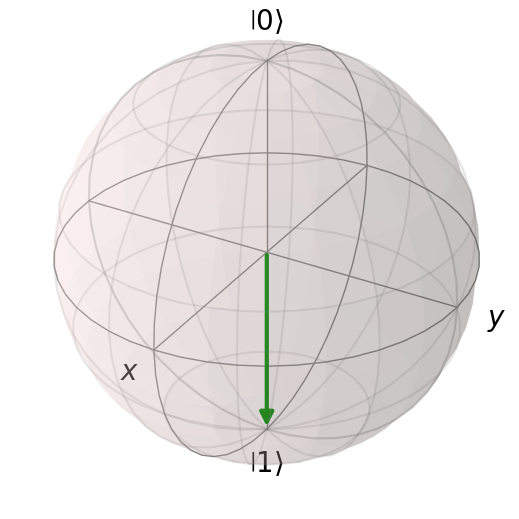

In [4]:
# Initial states
psi0_g = qt.tensor(qt.basis(N, 0), qt.basis(2, 1))  # qubit in ground state
visualize_bloch(psi0_g)

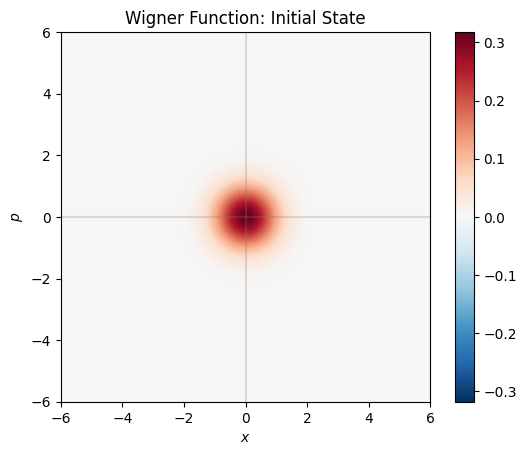

In [5]:
visualize_wigner(psi0_g, alpha, title="Wigner Function: Initial State")

### **Apply a π/2 Pulse to the Qubit**

$$\left| \psi_0 \right> \rightarrow \left| \psi_1 \right> = \frac{1}{\sqrt{2}} \left|0\right> \otimes \left[ \left| \mathrm{g} \right> + \left| \mathrm{e} \right> \right].$$


In [6]:
# Qubit drive
wd_q = wq + chi
T_drive_q = 10
amp_q = np.pi/2/T_drive_q
# amp_q = np.pi**2/4/T_drive_q
phase_q = -np.pi/2
ns_drive_q = int(round(fs * T_drive_q)) + 1
tlist_drive_q = np.linspace(0, T_drive_q, ns_drive_q)  # nanoseconds
# drive_q = amp_q * np.sin(np.pi/T_drive_q*tlist_drive_q)*np.exp(1j * ((wd_q - wrot_q) * tlist_drive_q + phase_q))
drive_q = amp_q * np.exp(1j * ((wd_q - wrot_q) * tlist_drive_q + phase_q))
drive_q = np.append(drive_q, np.zeros(ns_tot - ns_drive_q))

H3 = H + [
    [sm, 0.5 * drive_q],
    [sp, 0.5 * drive_q.conj()],
]

psi_1 = qt.mesolve(H3, psi0_g, tlist, c_ops=c_ops)

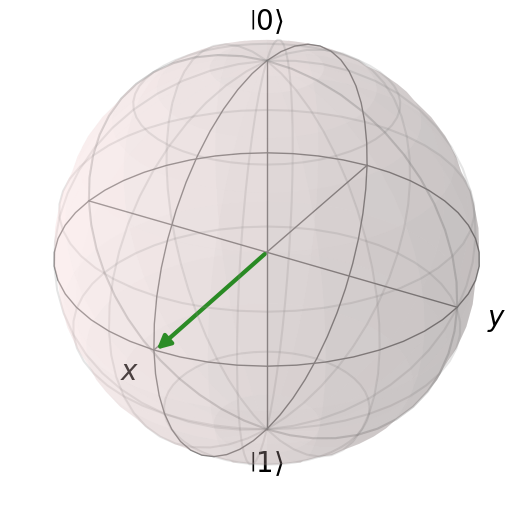

In [7]:
visualize_bloch(psi_1.states[-1])

### **Conditional Displacement of the Cavity**

$$\left| \psi_1 \right> \rightarrow \left| \psi_2 \right> = \frac{1}{\sqrt{2}} \left[ \left|2\alpha\right> \otimes \left| \mathrm{g} \right> + \left|0\right> \otimes \left| \mathrm{e} \right> \right].$$

In [8]:
# Cavity drive
T_drive_c = np.pi/chi
wd_c = wc - chi
amp_c = np.sqrt(2*2*alpha**2)*kappa/(1 - np.exp(-kappa*T_drive_c/2))
phase_c = -np.pi/2
ns_drive_c = int(round(fs * T_drive_c)) + 1
tlist_drive_c = np.linspace(T_drive_q, T_drive_c, ns_drive_c)  # nanoseconds
drive_c = amp_c * np.exp(1j * ((wd_c - wrot_c) * tlist_drive_c + phase_c))
drive_c = np.append(np.append(np.zeros(ns_drive_q), drive_c), np.zeros(ns_tot - ns_drive_c - ns_drive_q))


H4 = H3 + [
    [a, 0.5 * drive_c],
    [a.dag(), 0.5 * drive_c.conj()],
]

psi_2 = qt.mesolve(H4, psi0_g, tlist, c_ops=c_ops)

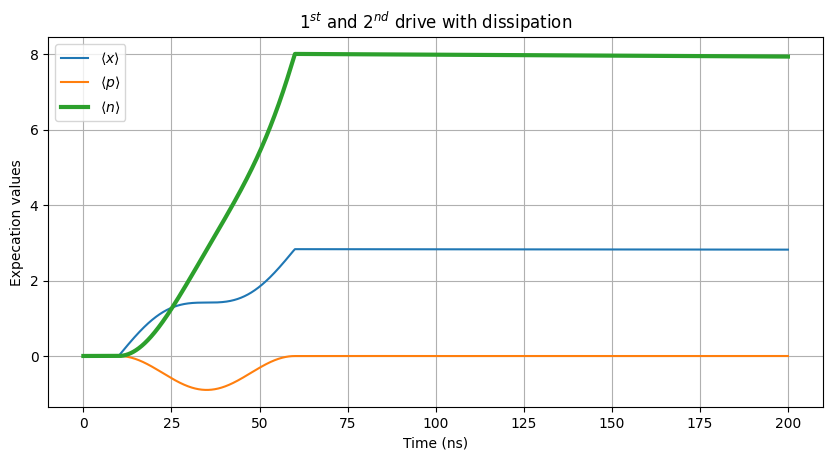

In [9]:
fig, axes = plt.subplots(1, 1)
titles = [r"$1^{st}$ and $2^{nd}$ drive with dissipation"]
for i in range(1):
    axes.plot(tlist, qt.expect(x, psi_2.states), label=r"$\left<x\right>$")
    axes.plot(tlist, qt.expect(p, psi_2.states), label=r"$\left<p\right>$")
    axes.plot(tlist, qt.expect(n, psi_2.states), lw=3, label=r"$\left<n\right>$")
    axes.set_title(titles[i])
    axes.set_ylabel(r"Expecation values")
    axes.set_xlabel(r"Time (ns)")
    axes.grid()
    axes.legend()

fig.set_figwidth(10)

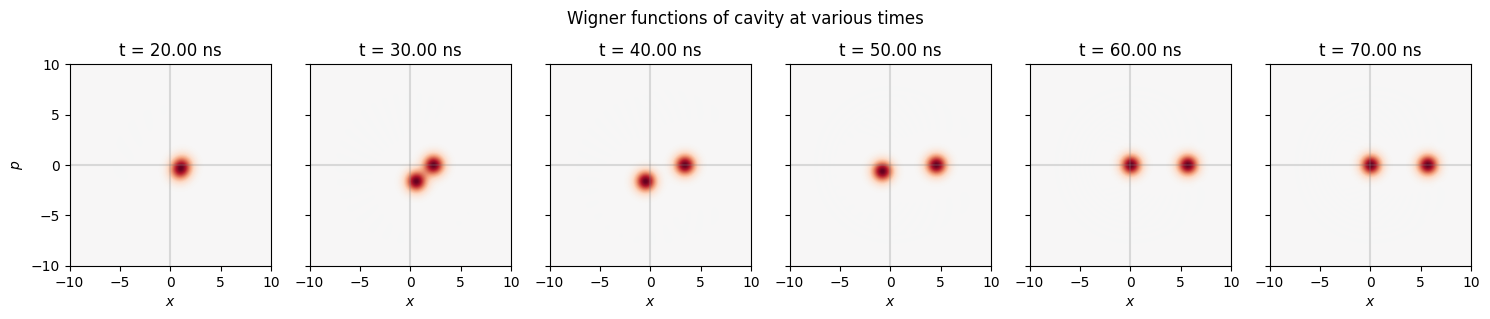

In [10]:
fig, axes = plt.subplots(1, 6, sharex=True, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(3)
fig.suptitle(r"Wigner functions of cavity at various times")

xvec = np.linspace(-10, 10, 200)

for axi, idx in enumerate(range(int(2 * ns_tot / 20), int(8 * ns_tot / 20), int(ns_tot / 20))):
    rho = qt.ptrace(psi_2.states[idx], 0)
    W = qt.wigner(rho, xvec, xvec)
    wlim = np.abs(W).max()

    axes[axi].imshow(
        W, cmap='RdBu_r', vmin=-wlim, vmax=wlim, origin="lower",
        extent=(xvec.min(), xvec.max(), xvec.min(), xvec.max()),
    )
    axes[axi].axhline(0.0, c="tab:gray", alpha=0.25)
    axes[axi].axvline(0.0, c="tab:gray", alpha=0.25)
    axes[axi].set_title(f"t = {tlist[idx]:.2f} ns")
    axes[axi].set_xlabel(r"$x$")

axes[0].set_ylabel(r"$p$")
plt.tight_layout()
plt.show()


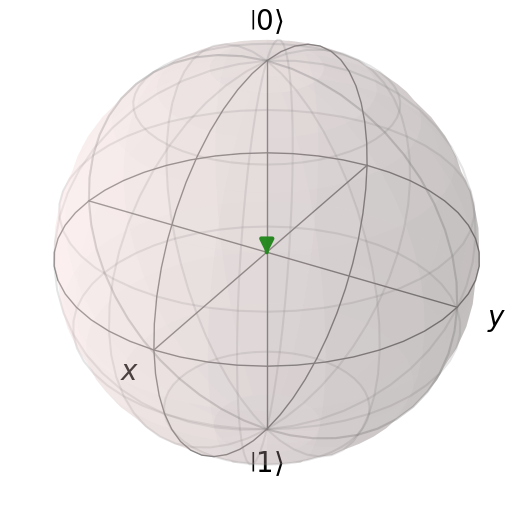

In [11]:
visualize_bloch(psi_2.states[-1])

### **Conditional Qubit Flip**

$$\left| \psi_2 \right> \rightarrow \left| \psi_3 \right> = \frac{1}{\sqrt{2}} \left[ \left|2\alpha\right> + \left|0\right> \right] \otimes \left| \mathrm{g} \right>.$$

In [12]:
# Qubit drive 2

wd_q2 = wq + chi
T_drive_q2 = np.pi/chi
amp_q2 = np.pi/T_drive_q2
phase_q2 = -np.pi/2
ns_drive_q2 = int(round(fs * T_drive_q2)) + 1
tlist_drive_q2 = np.linspace(T_drive_q + T_drive_c, T_drive_q2, ns_drive_q2)
drive_q2 = amp_q2 * np.exp(1j * ((wd_q2 - wrot_q) * tlist_drive_q2 + phase_q2))
drive_q2 = np.append(np.append(np.zeros(ns_drive_q + ns_drive_c), drive_q2), np.zeros(ns_tot - ns_drive_c - ns_drive_q - ns_drive_q2))

H5 = (H4 + [
    [sm, 0.5 * drive_q2],
    [sp, 0.5 * drive_q2.conj()],
])

psi_3 = qt.mesolve(H5, psi0_g, tlist, c_ops=c_ops)

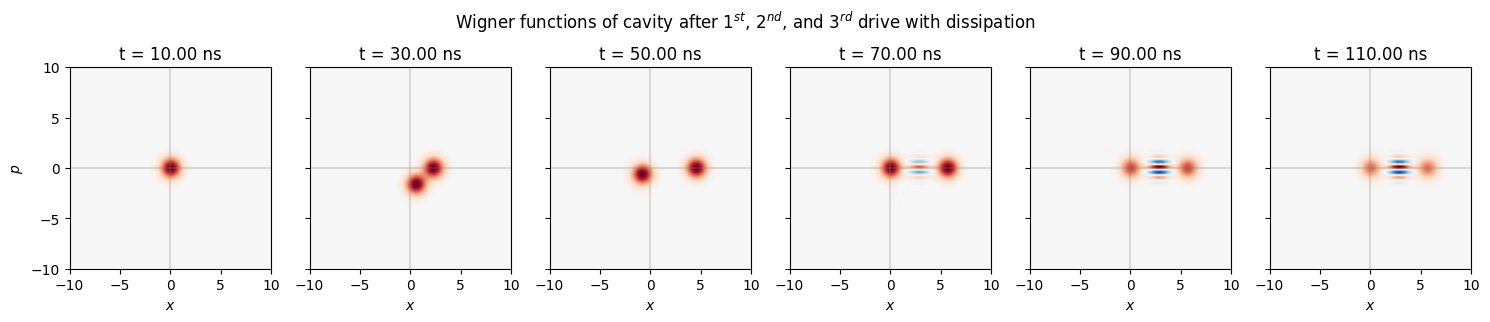

In [13]:
fig, axes = plt.subplots(1, 6, sharex=True, sharey=True)
fig.set_figwidth(15)
fig.set_figheight(3)
fig.suptitle(r"Wigner functions of cavity after $1^{st}$, $2^{nd}$, and $3^{rd}$ drive with dissipation")

xvec = np.linspace(-10, 10, 200)

for axi, idx in enumerate(range(int(ns_tot / 20), int(12 * ns_tot / 20), int(ns_tot / 10))):
    rho = qt.ptrace(psi_3.states[idx], 0)
    W = qt.wigner(rho, xvec, xvec)
    wlim = np.abs(W).max()

    axes[axi].imshow(
        W, cmap='RdBu_r', vmin=-wlim, vmax=wlim, origin="lower",
        extent=(xvec.min(), xvec.max(), xvec.min(), xvec.max()),
    )
    axes[axi].axhline(0.0, c="tab:gray", alpha=0.25)
    axes[axi].axvline(0.0, c="tab:gray", alpha=0.25)
    axes[axi].set_title(f"t = {tlist[idx]:.2f} ns")
    axes[axi].set_xlabel(r"$x$")

axes[0].set_ylabel(r"$p$")
plt.tight_layout()
plt.show()


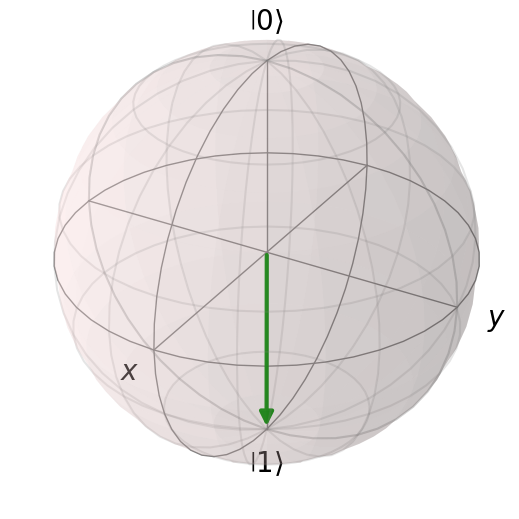

In [14]:
visualize_bloch(psi_3.states[-1])

### **Final Displacement**

$$\left| \psi_3 \right> \rightarrow \left| \psi_4 \right> = \frac{1}{\sqrt{2}} \left[ \left|\alpha\right> + \left|-\alpha\right> \right] \otimes \left| \mathrm{g} \right>.$$

In [15]:
# Cavity drive 2

wd_c2 = wc - chi
# T_drive_c2 = np.abs(1*np.pi/chi)
T_drive_c2 = 10
amp_c2 = np.sqrt(alpha**2)*kappa/(1 - np.exp(-kappa*T_drive_c2/2))
phase_c2 = np.pi/2
ns_drive_c2 = int(round(fs * T_drive_c2)) + 1
tlist_drive_c2 = np.linspace(T_drive_q + T_drive_c + T_drive_q2, T_drive_c2, ns_drive_c2)  # nanoseconds
drive_c2 = amp_c2 * np.exp(1j * ((wd_c2 - wrot_c) * tlist_drive_c2 + phase_c2))
drive_c2 = np.append(np.append(np.zeros(ns_drive_q + ns_drive_c + ns_drive_q2), drive_c2), \
                    np.zeros(ns_tot - ns_drive_c - ns_drive_q - ns_drive_q2 - ns_drive_c2))

H6 = H5 + [
    [a, 0.5 * drive_c2],
    [a.dag(), 0.5 * drive_c2.conj()],
]

psi_4 = qt.mesolve(H6, psi0_g, tlist, c_ops=c_ops)

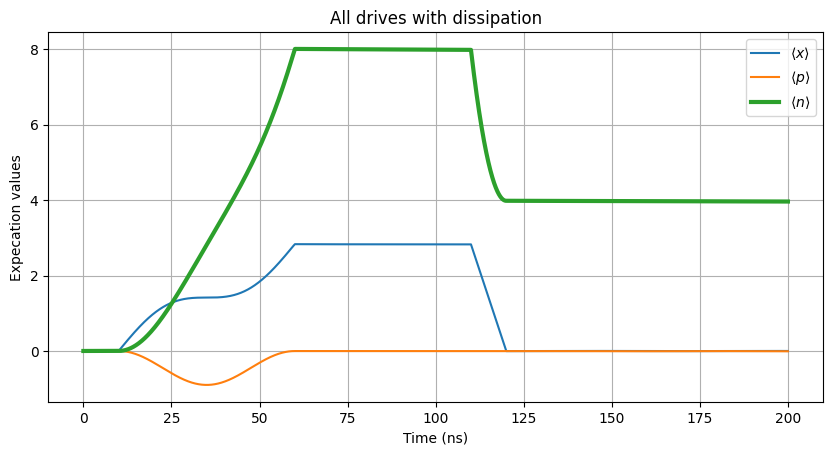

In [16]:
fig, axes = plt.subplots(1, 1)
titles = [r"All drives with dissipation"]


axes.plot(tlist, qt.expect(x, psi_4.states), label=r"$\left<x\right>$")
axes.plot(tlist, qt.expect(p, psi_4.states), label=r"$\left<p\right>$")
axes.plot(tlist, qt.expect(n, psi_4.states), lw=3, label=r"$\left<n\right>$")
axes.set_title(titles[0])
axes.set_ylabel(r"Expecation values")
axes.set_xlabel(r"Time (ns)")
axes.grid()
axes.legend()

fig.set_figwidth(10)

Text(0.5, 0.98, 'Wigner functions of cavity all drives with dissipation')

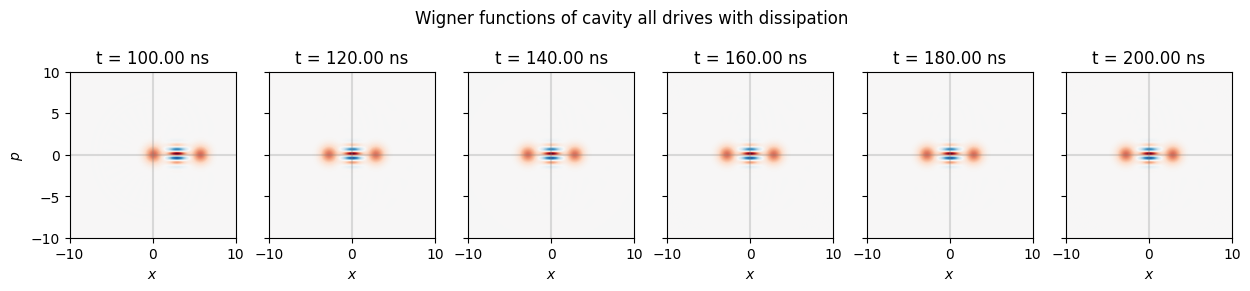

In [17]:
fig, axes = plt.subplots(1, 6, sharex=True, sharey=True)

title = r"Wigner functions of cavity all drives with dissipation"

xvec = np.linspace(-10, 10, 200)
for axi, idx in enumerate(range(int(10*ns_tot/20), int(ns_tot), int(ns_tot/10))):
    rho = qt.ptrace(psi_4.states[idx], 0)
    W = qt.wigner(rho, xvec, xvec)
    wlim = np.abs(W).max()
    axes[axi].imshow(
        W, cmap='RdBu_r', vmin=-wlim, vmax=wlim, origin="lower",
        extent=(xvec.min(), xvec.max(), xvec.min(), xvec.max()),
    )
    axes[axi].axhline(0.0, c="tab:gray", alpha=0.25)
    axes[axi].axvline(0.0, c="tab:gray", alpha=0.25)
    axes[axi].set_title(f"t = {tlist[idx]:.2f} ns")
    axes[axi].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$p$")
fig.set_figwidth(15)
fig.set_figheight(3)
fig.suptitle(title)


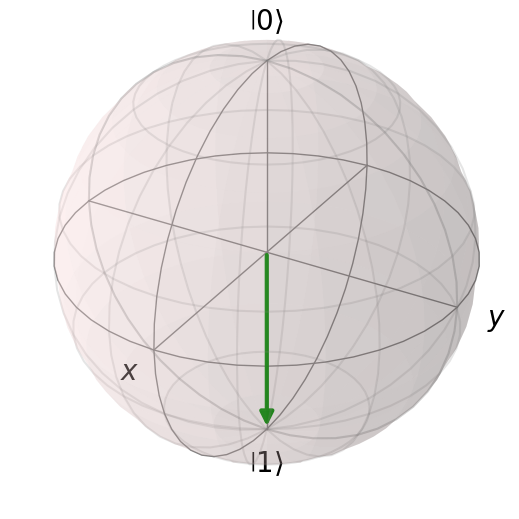

In [18]:
visualize_bloch(psi_4.states[-1])